**Safeguarding Personal Privacy by Using Adversarial Machine Learning Against Invasive Facial Recognition Models**

Submitted to 2024 Jersey City Medical Center STEM Showcase

By Arnav Ambre

Note: This notebook contains the targeted version of my projected gradient descent adversarial model. This means it aims to generate a comprehensive adversarial image that causes the VGG-Face model to misidentify it as the targeted image class.

Mount Google Drive and install all libraries.

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
!pip install git+https://github.com/yaledhlab/vggface.git

  Cloning https://github.com/yaledhlab/vggface.git to /tmp/pip-req-build-_wli79yy
  Running command git clone --filter=blob:none --quiet https://github.com/yaledhlab/vggface.git /tmp/pip-req-build-_wli79yy
  Resolved https://github.com/yaledhlab/vggface.git to commit b76539b7588bca69b0030ad7e4f985f877dc7c0a
  Preparing metadata (setup.py) ... done
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8332 sha256=d991941f633f24107f4441533683a8e3ba38106a9ebed6ca8f582626691d2c30
  Stored in directory: /tmp/pip-ephem-wheel-cache-aar36aqv/wheels/79/35/65/07a23ffb182ac2ec3a43776e08b2cf52daf0ce54da686eefbe
Successfully built keras-vggface


Import required libraries and load the pre-trained VGG Face model.

In [6]:
!pip install keras_applications

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 1.3 MB/s eta 0:00:00


In [7]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input as vgg_preprocess_input
from keras_vggface.utils import decode_predictions as vgg_decode_predictions

import tensorflow as tf
import numpy as np
import cv2

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

from google.colab.patches import cv2_imshow
import datetime

print("[INFO] loading pre-trained VGGFACE model...")
model = VGGFace(model='resnet50', input_shape=(224, 224, 3), weights='vggface', pooling="avg")

[INFO] loading pre-trained VGGFACE model...
165445632/165439116 [==============================] - 2s 0us/step


Load the Spare Categorical Crossentropy loss model.

In [8]:
print("[INFO] loading loss model...")
sccLoss = SparseCategoricalCrossentropy()
lossModel = "SCC"

[INFO] loading loss model...


Declare a few helper/utility functions. The generate_adversaries function is the meat of this research - it uses projected gradient descent to iteratively generate an adversarial image over the specified number of steps.

In [9]:
def preprocess_image(image):
    image = image.astype("float32")
    image = np.expand_dims(image, axis=0)
    return image

def clip_eps(tensor, eps):
	return tf.clip_by_value(tensor, clip_value_min=-eps,
		clip_value_max=eps)

def save_adversaries(adversary, predictions, step, loss="NA"):
    adverImage = adversary.numpy()
    adverImage = adverImage.squeeze()
    cv2.imwrite(imgPath + lossModel + "/mask/" + originalInitials + "Mask" + lossModel + str(step) + ".png", (adverImage - originalImage.squeeze())*50)

    predictions = vgg_decode_predictions(predictions, top=3)[0]

    adverImage = cv2.putText(adverImage, predictions[0][0][2:-1] + ": " + str(round(predictions[0][1]*100)) + "%", (-7, 210), cv2.FONT_HERSHEY_SIMPLEX, 0.55, (0,255,0), 1)
    adverImage = cv2.putText(adverImage, str(step), (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)

    log.write("Iteration #" + str(step) + "\n")
    log.write("Loss: " + loss + "\n")
    for i in range(len(predictions)):
      logPrediction = "Prediction #" + str(i) + ": "
      logPrediction += predictions[i][0][2:-1] + " (" + str(round(predictions[i][1]*100, 2)) + "%)\n"
      log.write(logPrediction)

    log.write("\n")
    cv2.imwrite(imgPath + lossModel + "/adversary/" + originalInitials + lossModel + str(step) + ".png", adverImage)
    cv2_imshow(adverImage.squeeze())

def generate_adversaries(baseImage, classIdx, targetIdx, epsilon=0.1, steps=50):
    adversary = vgg_preprocess_input(baseImage)
    adversary = tf.convert_to_tensor(baseImage)
    print(baseImage[0][0][0])
    for step in range(0, steps):
        with tf.GradientTape() as tape:
            tape.watch(adversary)

            predictions = model(adversary)

            originalLoss = sccLoss(tf.convert_to_tensor([classIdx]), predictions)
            targetLoss = -sccLoss(tf.convert_to_tensor([targetIdx]), predictions)

            totalLoss = originalLoss + targetLoss

            if step % 5 == 0:
                print("step: {}, loss: {}...".format(step, totalLoss.numpy()))
                save_adversaries(adversary, predictions.numpy(), step, str(totalLoss.numpy()))

        gradients = tape.gradient(totalLoss, adversary)
        delta = tf.sign(gradients)
        adversary = tf.clip_by_value(adversary + epsilon * delta, 0, 255)

    return adversary


Load input image and declare a few paramaters for the targeted adversarial model.
- epsilon: the multiplier applied to the "mask." A higher number will result in a faster convergence, but might result in more image artifacts.
- originalImageClass: the ID that corresponds to the input image class.
- personInitials: the initials of the person in the input image, used for filesystem access.
- targetImageClass: the target class the adversarial model will attempt to converge towards. Arbitrarily chosen to be 500 greater than the input image class for testing purposes.

[INFO] loading image...
/content/drive/MyDrive/VGG_Face_Images_Targeted/dj/dj.png


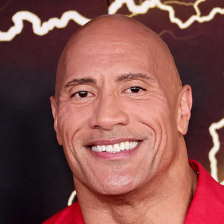

In [10]:
epsilon = 0.25

originalImageClass = 2168
originalInitials = "dj"
targetImageClass = originalImageClass + 500
targetName = "Franciszek_Smuda"

imgPath = "/content/drive/MyDrive/VGG_Face_Images_Targeted/" + originalInitials + "/"

print("[INFO] loading image...")
print(imgPath + originalInitials + ".png")
originalImage = cv2.imread(imgPath + originalInitials + ".png")
cv2_imshow(originalImage)

originalImage = preprocess_image(originalImage)
baseImage = tf.constant(originalImage, dtype=tf.float32)

Run the targeted model and open a log file to store the progress of the adversarial model every 5 steps.

1351680/1346516 [==============================] - 0s 0us/step
[INFO] generating perturbation...
tf.Tensor([31. 20. 53.], shape=(3,), dtype=float32)
step: 0, loss: -12.968812942504883...


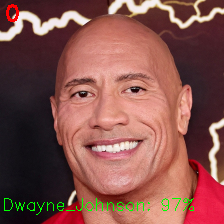

step: 5, loss: -3.680633544921875...


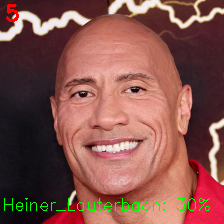

step: 10, loss: 4.607206344604492...


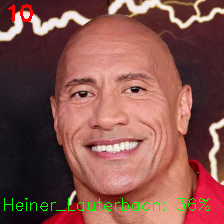

step: 15, loss: 10.532835960388184...


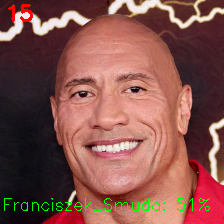

step: 20, loss: 15.471936225891113...


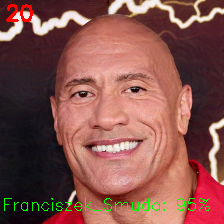

step: 25, loss: 19.513702392578125...


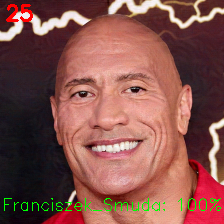

step: 30, loss: 23.023365020751953...


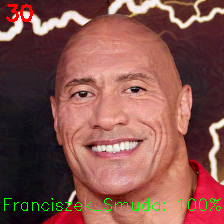

step: 35, loss: 26.17435646057129...


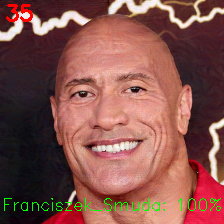

step: 40, loss: 28.766983032226562...


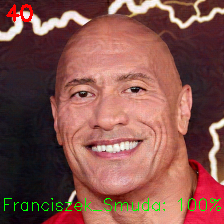

step: 45, loss: 31.064058303833008...


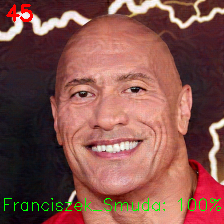

step: 50, loss: 33.141754150390625...


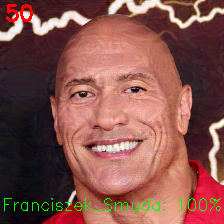

step: 55, loss: 34.74881362915039...


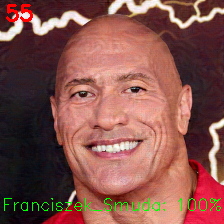

step: 60, loss: 36.39751052856445...


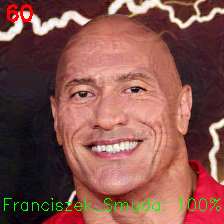

step: 65, loss: 37.79972839355469...


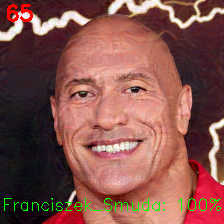

step: 70, loss: 39.18156051635742...


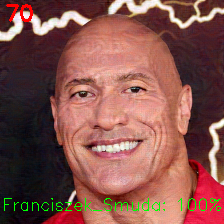

step: 75, loss: 40.36857223510742...


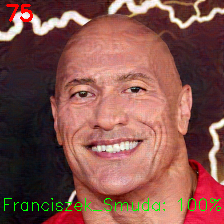

step: 80, loss: 41.502784729003906...


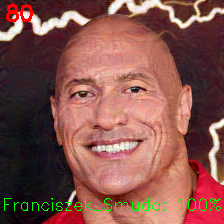

step: 85, loss: 42.57487487792969...


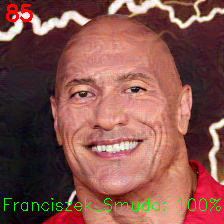

step: 90, loss: 43.717201232910156...


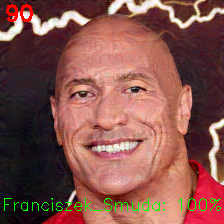

step: 95, loss: 44.66549301147461...


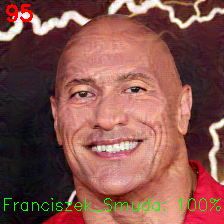

step: 100, loss: 45.76850509643555...


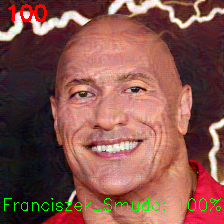

step: 105, loss: 46.797000885009766...


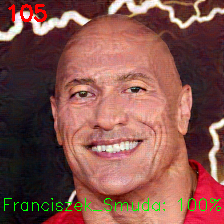

step: 110, loss: 47.8336181640625...


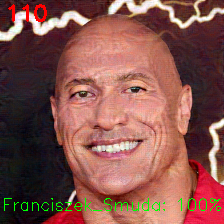

step: 115, loss: 48.6871337890625...


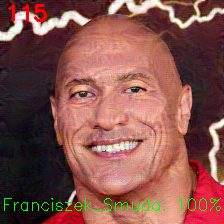

step: 120, loss: 49.530250549316406...


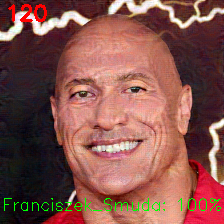

step: 125, loss: 50.3426513671875...


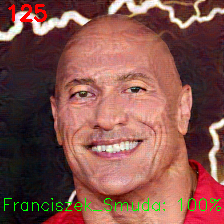

step: 130, loss: 51.16956329345703...


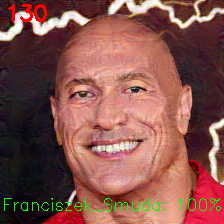

step: 135, loss: 51.98579788208008...


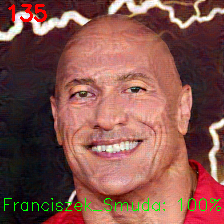

step: 140, loss: 52.76804733276367...


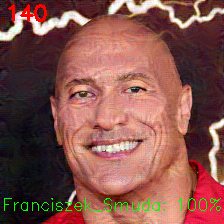

step: 145, loss: 53.50762939453125...


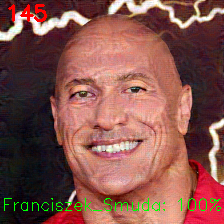

1/1 [==============================] - 0s 310ms/step


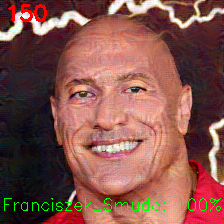

In [11]:
predictions = model.predict(originalImage)
predictions = vgg_decode_predictions(predictions, top=3)[0]

log = open(imgPath + "log.txt", "a")
log.write("*****NEW LOG STARTED\n")
log.write("Time: " + str(datetime.datetime.now()) + "\n")
log.write("Loss Model: " + lossModel + "\n")
log.write("Original person & class: " + predictions[0][0][2:-1] + " (" +  str(originalImageClass) + ")\n")
log.write("Target person & class: " + targetName + " (" +  str(targetImageClass) + ")\n\n")

numIter = 150
print("[INFO] generating perturbation...")
adverImage = generate_adversaries(baseImage, originalImageClass, targetImageClass, epsilon, numIter)

predictions = model.predict(adverImage.numpy())

save_adversaries(adverImage, predictions, numIter)
log.close()